# 3. PSF modeling and subtraction

> Authors: *Carlos Alberto Gomez Gonzalez* and *Valentin Christiaens*  
> Suitable for VIP *v1.0.0* onwards  
> Last update: *2022/03/16*

**Table of contents**

* [3.1. Loading ADI data](#3.1.-Loading-ADI-data)
* [3.2. median-ADI](#3.2.-median-ADI)
    - [3.2.1. Full-frame median-ADI](#3.2.1.-Full-frame-median-ADI)
    - [3.2.2. Smart median-ADI](#3.2.2.-Smart-median-ADI)
* [3.3. Pairwise frame difference](#3.3.-Pairwise-frame-difference)
* [3.4. Least-squares approximation - LOCI](#3.4.-Least-squares-approximation---LOCI)
* [3.5. PCA](#3.5.-PCA)
    - [3.5.1. Full-frame PCA](#3.5.1.-Full-frame-PCA)
    - [3.5.2. Optimizing the number of PCs for full-frame PCA-ADI](#3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI)
    - [3.5.3. Full-frame  PCA-ADI with a parallactic angle threshold](#3.5.3.-Full-frame-PCA-ADI-with-a-parallactic-angle-threshold)
    - [3.5.4. PCA for big datacubes](#3.5.4.-PCA-for-big-datacubes)
    - [3.5.5. Annular PCA](#3.5.5.-Annular-PCA)
    - [3.5.6. PCA in a single annulus](#3.5.6.-PCA-in-a-single-annulus)
* [3.6. NMF](#3.6.-NMF)
    - [3.6.1. Full-frame NMF](#3.6.1.-Full-frame-NMF)
    - [3.6.2. Annular NMF](#3.6.2.-Annular-NMF)
* [3.7. LLSG](#3.7.-LLSG)
* [3.8. ANDROMEDA](#3.8.-ANDROMEDA)
* [3.9. Summary mosaic](#3.9.-Summary-mosaic)

This tutorial shows:

- how to load ADI-ready datacubes; 
- how to use the stellar PSF subtraction algorithms implemented in VIP to produce final post-processed images (more details and higher completeness than the quick-start tutorial).

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.andromeda import andromeda
    from vip_hci.conf import VLT_NACO
    from vip_hci.frdiff import frame_diff
    from vip_hci.leastsq import xloci
    from vip_hci.llsg import llsg
    from vip_hci.medsub import median_sub
    from vip_hci.metrics import normalize_psf
    from vip_hci.metrics import compute_stim_map as stim_map
    from vip_hci.metrics import compute_inverse_stim_map as inverse_stim_map
    from vip_hci.nmf import nmf, nmf_annular
    from vip_hci.pca import pca, pca_annular, pca_annulus, pca_grid
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import normalize_psf
    from vip_hci.invprob import andromeda
    from vip_hci.metrics import inverse_stim_map, stim_map
    from vip_hci.psfsub import (frame_diff, llsg, median_sub, nmf, nmf_annular,
                                pca, pca_annular, pca_annulus, pca_grid, xloci)
    
# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import significance, snr, snrmap
from vip_hci.var import fit_2dgaussian, frame_center

VIP version:  1.1.1


## 3.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO coronagraphic (VORTEX AGPM) dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract). The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the datacube, associated parallactic angles and non-coronagraphic PSF:

In [3]:
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'
psfnaco = '../datasets/naco_betapic_psf.fits'

cube = open_fits(cubename)
pa = open_fits(angname)
psf = open_fits(psfnaco)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (61,)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)


<font color=orange> **Question 1.1:** When observing a celestial object with a given telecope, what 3 parameters do the values of parallactic angle depend on? </font>

**Note**: throughout this notebook, questions will be raised in <font color=orange>orange</font>. Corresponding answers will be provided in <font color=green>green</font> at the end of the respective (sub)sections.

In [4]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)

angs = pa+derot_off+TN

Let's measure the FWHM by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

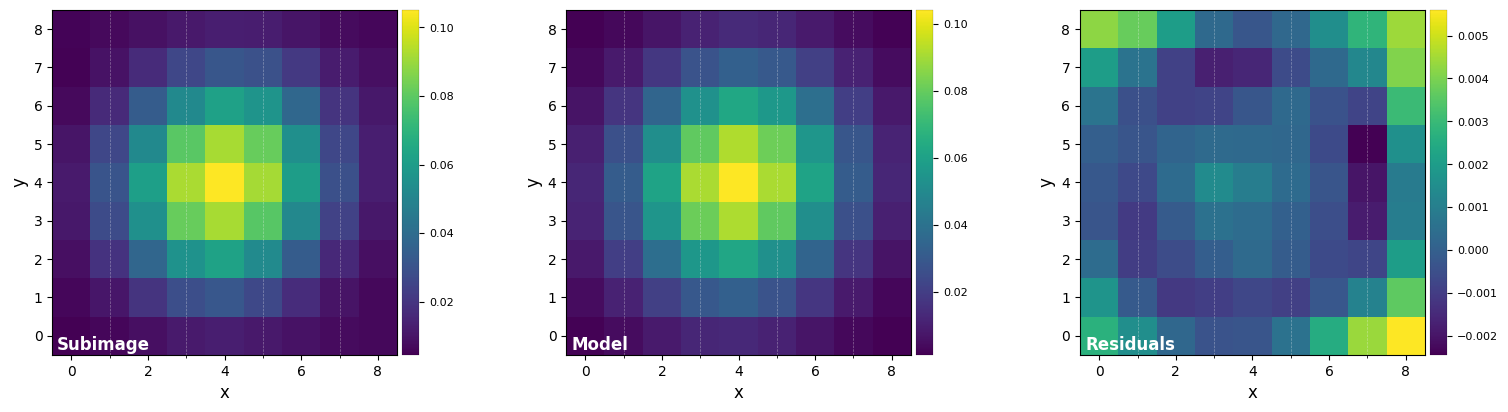

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [5]:
%matplotlib inline
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [6]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.603450563658683


<font color=orange> **Question 3.2:** The FWHM measured above can slightly vary depending on observing conditions and quality of the adaptive optics (AO) correction. In excellent conditions, the PSF gets narrower and can approach the theoretical diffraction limit. What is that angular resolution (in arcsec and in pixels) at L' band, for a 8.1m diameter telescope such as the VLT?</font>

Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [7]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


The `normalize_psf` function performs internally a fine centering of the PSF (note the input PSF should already be centered within a few pixel accuracy for this fine centering to work). The `imlib` argument sets the library to be used for sub-px shifts (more details in `Tutorial 7`).

Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` (default) allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

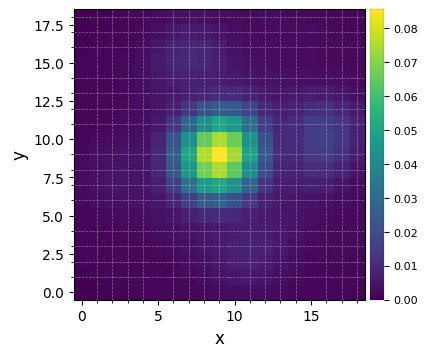

In [8]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `conf` subpackage:

In [9]:
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


<font color=orange> **Question 3.3:** When building an instrument, one wants to make sure that even in the best observing conditions the PSF is always sampled at least at the Nyquist frequency - what would then be the coarsest pixel scale that would still allow a Nyquist sampling of the PSF at L' at the VLT? </font>

<font color=green> **Answer 3.1**: The parallactic angle depends on the celestial coordinates of the target, the latitude of the observatory and the observation time (commonly expressed in local hour angle for the target).</font> 

<font color=green> **Answer 3.2**: The theoretical diffraction limit is $\sim \lambda/D$, or $\sim$ 0.10 arcsec after conversion from radian to arcsec. This is $\sim$3.9 pixels at the NACO pixel scale. </font> 

<font color=green> **Answer 3.3**: A maximum pixel scale of 0.05 arcsec/px is required to ensure Nyquist sampling at L' band even in the best observing conditions.</font> 

[Go to the top](#Table-of-contents)

## 3.2. median-ADI

In the framework of differential imaging techniques, we ultimately rely on modelling and subtracting the stellar PSF and associated speckle noise pattern. Algorithms of different complexities and performances have been proposed since 2006. Several of those algorithms are implemented in ``VIP`` and showcased in the next subsections.

When loading the ADI cube above, we assumed all calibration and preprocessing steps were already performed. In particular, the star is assumed to be already centered in the images. If your data require calibration/preprocessing, feel free to check tutorial `2. Pre-processing` for example uses of VIP preprocessing routines on NACO and SPHERE/IFS data.

**IMPORTANT** - VIP's convention regarding centering is:
- for **odd** number of pixels along the x and y directions: the star is placed on the central pixel;
- for **even** number of pixels: the star is placed on coordinates (dim/2,dim/2) in 0-based indexing.

All ADI-based algorithms involve image rotation. We therefore first set the preferred method to be used for image rotation. This is controlled with the `imlib` and `interpolation` optional arguments (see tutorial `7. FFT- vs. interpolation-based image operations` for more details). Feel free to adapt the following box to test other methods (keeping in mind that FFT-based rotation is only available in versions >= 1.0.0).

In [10]:
imlib_rot = 'vip-fft'
interpolation=None

### 3.2.1. Full-frame median-ADI

The most simple approach is to model the PSF with the median of the ADI sequence. The median subtraction algorithm is the original post-processing approach proposed for ADI data (see [Marois et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJ...641..556M/abstract)):

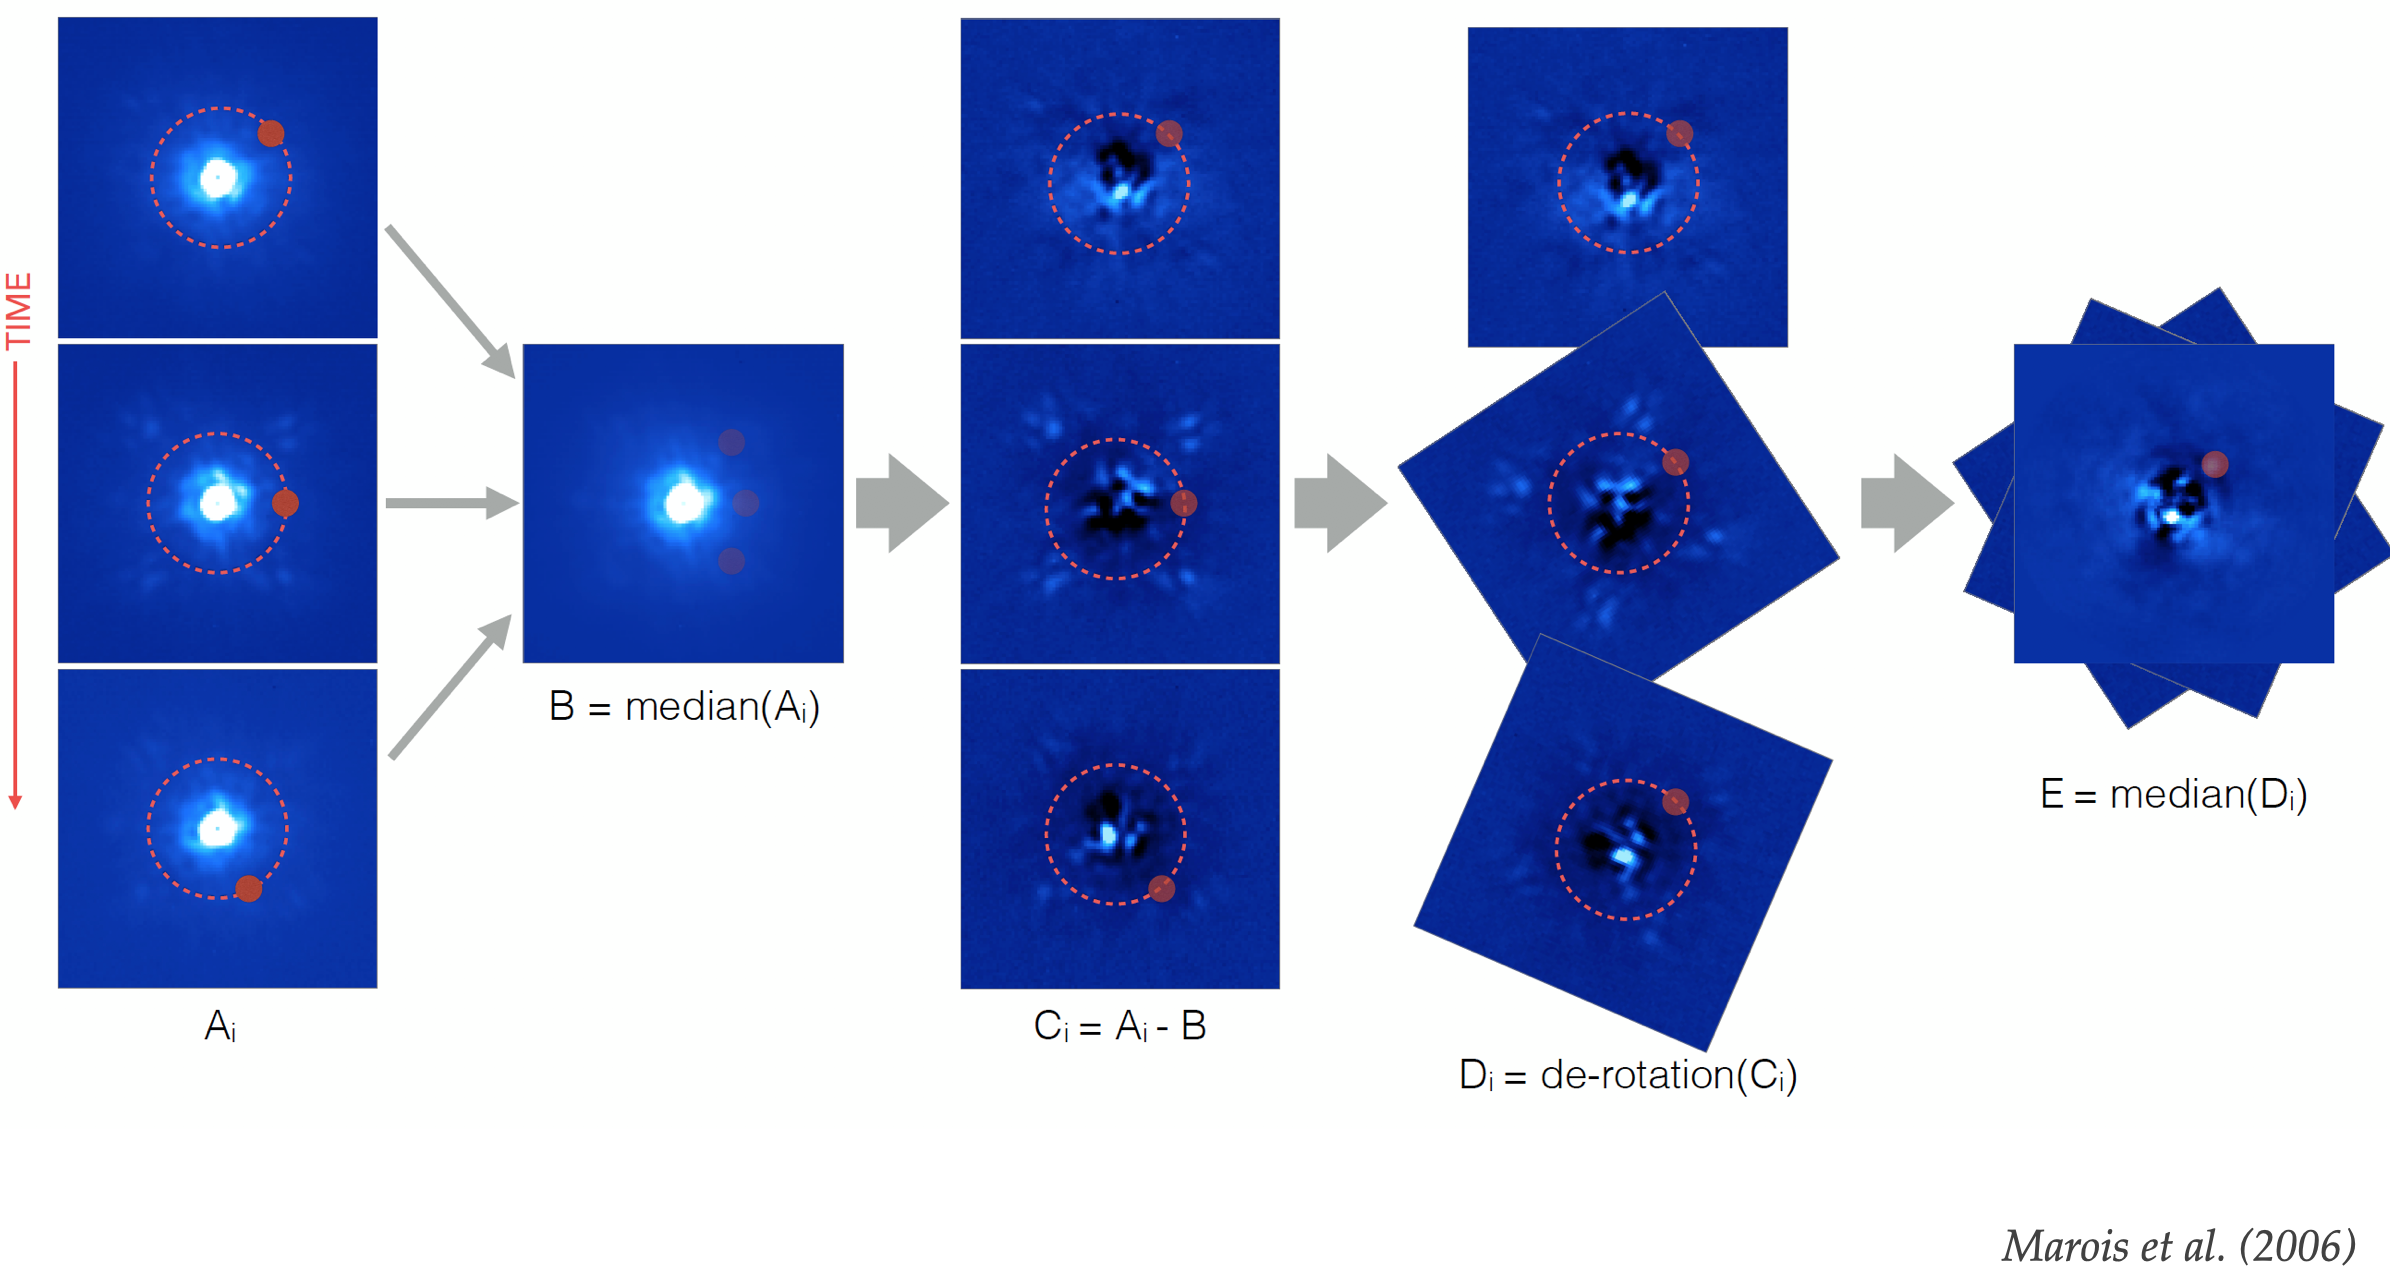

**Figure 3.1** - Median-ADI concept. A sequence of images $A_i$ is obtained in pupil-tracking mode. Any putative planet would rotate throughout the images, along with the field of view, while the stellar halo and speckle pattern remains quasi-static. The median $B_i$ of the sequence does not compare and is subtracted to $A_i$ to create a residual cube $C_i$. The residual cube is derotated ($D_i$) to align the field-of-view. The derotated residual cube is then stacked (typically with a median) to create a finale image $E$.

<font color=orange>**Question 3.4**: In practice, what are the main limitations of median-ADI? </font>

In [11]:
fr_adi = median_sub(cube, angs, mode='fullfr', imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:38:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:01.219554
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


[Go to the top](#Table-of-contents)

### 3.2.2. Smart median-ADI

A "smart median-ADI" can be performed in concentric annuli and using a parallactic angle threshold. For each image of the input cube the subtracted model consists of the median of the `nframes` closest images in time that have rotated by at least `delta_rot`x FWHM (linear motion) - i.e. it is a different model PSF for each image. This model is constructed in concentric annuli of width `asize`x FWHM, starting at `radius_int` pixels radius (i.e. the inner `radius_int` pixels are masked).

<font color=orange> **Question 3.5**: What are the pros and cons of using a parallactic angle threshold? </font>

In [12]:
fr_adi_an = median_sub(cube, angs, fwhm_naco, asize=fwhm_naco, mode='annular', delta_rot=0.5, 
                       radius_int=4, nframes=4, imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:38:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4
Processing annuli:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:00:01.401258
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Note that the parallactic angle threshold corresponding to 0.5 FWHM linear motion could not be met for the innermost annulus, and was therefore automatically relaxed to find `nframes` eligible frames to be used for the model.

Let's vizualize the final images:

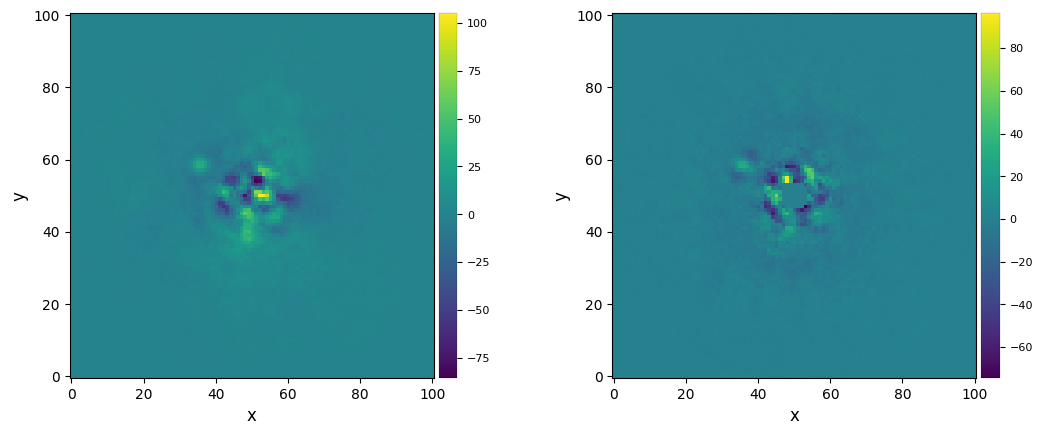

In [13]:
plot_frames((fr_adi, fr_adi_an))

Strong residuals can be seen near the center of the image, with a faint potential point source in the north-east of the final image:

<font color=green> **Answer 3.4** Quasi-static speckles (i.e. not exactly static) are one of the main limitations. These stem from slowly varying aberrations in the instrument and optics while tracking the object during the observation (due e.g. to different mechanical flexures, imperfections in the mirrors, non-common path aberrations in the instrument). If observing conditions are not stable (e.g. sudden bursts in seeing), the adaptive optics performance may also fluctuate during the observing sequence, which can also lead to a decorrelation of the speckle pattern. The latter should be mitigated with bad frame removal (done in preprocessing).

<font color=green> **Answer 3.5** A non-zero parallactic angle threshold helps minimizing self-subtraction of putative planets, by only bulding a model for subtraction using images where a putative planet has sufficiently rotated. On the other hand, a large parallactic angle threshold can force the use of images taken far away in time from the one considered for modeling. The decorrelation of quasi-static speckle can then lead to a poor PSF model for subraction. While a value of `delta_rot=1` will lead to low self-subtraction and is a good default value for observations obtained in *good* and *stable* conditions with *sufficient field rotation*, keep in mind that the optimal value of `delta_rot` for a specific dataset and given planet radial separation may be different than 1.

[Go to the top](#Table-of-contents)

## 3.3. Pairwise frame difference

Another simple approach is to perform pairwise frame subtraction, taking into account both a rotation and distance (similarity) threshold.
For this example, we select the L1-distance metric, with a distance threshold set to the 90th percentile of all distances, a 0.5xFWHM linear rotation threshold, an innermost radius starting at 2 px, and an annular size set to `fwhm_naco` pixels.

In [14]:
fr_fdiff = frame_diff(cube, angs, fwhm_naco, metric='l1', dist_threshold=90, delta_rot=0.5, 
                      radius_int=4, asize=fwhm_naco, nproc=None, imlib=imlib_rot, 
                      interpolation=interpolation, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:38:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
10 annuli. Performing pair-wise subtraction:
Ann 1    PA thresh: 20.70    Ann center:   6    N segments: 1 Ann 2    PA thresh: 12.05    Ann center:  11    N segments: 1 Ann 4    PA thresh:  6.55    Ann center:  20    N segments: 1 Ann 3    PA thresh:  8.49    Ann center:  16    N segments: 1 



Ann 5    PA thresh:  5.33    Ann center:  25    N segments: 1 
Ann 6    PA thresh:  4.50    Ann center:  29    N segments: 1 
Ann 7    PA thresh:  3.89    Ann center:  34    N segments: 1 
Ann 8    PA thresh:  3.42    Ann center:  39    N segments: 1 
Ann 9    PA thresh:  3.06    Ann center:  43    N segments: 1 Ann 10    PA thresh:  2.82    Ann center:  47    N segments: 1 

Done processing annuli
Running time:  0:00:05.557353
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's vizualize the final image:

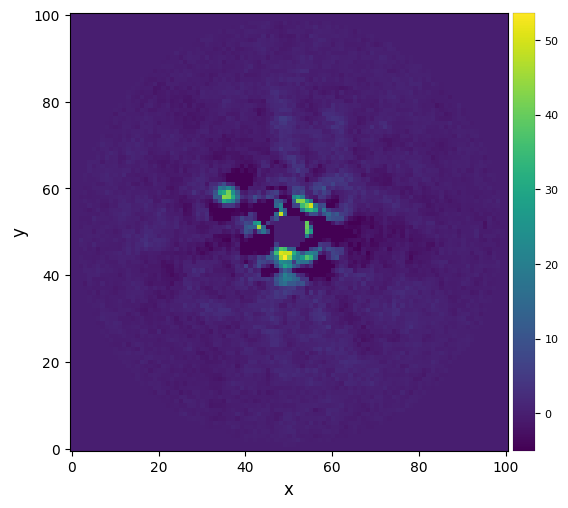

In [15]:
plot_frames(fr_fdiff, vmin=-5)

As for the median-ADI results, there seems to be a faint point-like source towards the north-east, although strong residuals dominate the center of the image.

[Go to the top](#Table-of-contents)

## 3.4. Least-squares approximation - LOCI

A continuation of the idea of imposing a rotation/PA threshold was proposed by [Lafreniere et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007ApJ...660..770L/abstract), but this time working in annular patches and using a more sophisticated model PSF. In this case the model PSF is built as a Locally Optimized linear Combination of Images (after discarding the ones that have not rotated enough). The coefficients of the linear combination are found to minimize local residuals in each annular subsection (i.e. locally optimized).

In [16]:
fr_lstsq = xloci(cube, angs, fwhm=fwhm_naco, asize=fwhm_naco, n_segments='auto', nproc=None, 
                 metric='correlation', dist_threshold=90, delta_rot=0.1, optim_scale_fact=2,
                 solver='lstsq', tol=0.01, imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:38:51
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Building 10 annuli:
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 2 
Ann 2    PA thresh:  3.82    Ann center:   7    N segments: 3 
Ann 3    PA thresh:  2.29    Ann center:  12    N segments: 5 
Ann 4    PA thresh:  1.64    Ann center:  16    N segments: 7 
Ann 5    PA thresh:  1.27    Ann center:  21    N segments: 9 
Ann 6    PA thresh:  1.04    Ann center:  25    N segments: 11 
Ann 7    PA thresh:  0.88    Ann center:  30    N segments: 12 
Ann 8    PA thresh:  0.76    Ann center:  35    N segments: 14 
Ann 9    PA thresh:  0.67    Ann center:  39    N segments: 16 
Ann 10    PA thresh:  0.62    Ann center:  43    N segments: 18 
Patch-wise least-square combination and subtraction: with 5 processes
Done processing annuli
Running time:  0:00:13.151827
――――――――――――――――――――――――


Let's vizualize the final image:

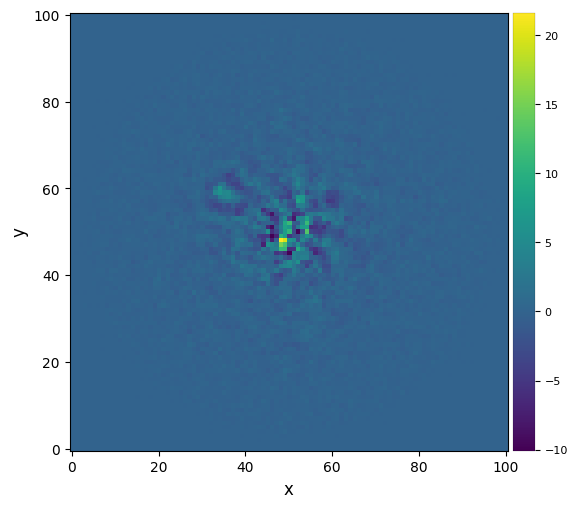

In [17]:
plot_frames(fr_lstsq)

This time the residuals are better subtracted. But the companion candidate also suffers significant self-subtraction. Note as well the comparatively longer processing time.

[Go to the top](#Table-of-contents)

## 3.5. PCA

### 3.5.1. Full-frame PCA

Now let's try the PCA-based algorithms ([Amara & Quanz 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..948A/abstract), [Soummer et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...755L..28S/abstract)) in `vip.pca`. As a reminder, below is a schematics summarizing how full-frame PCA-ADI works: 

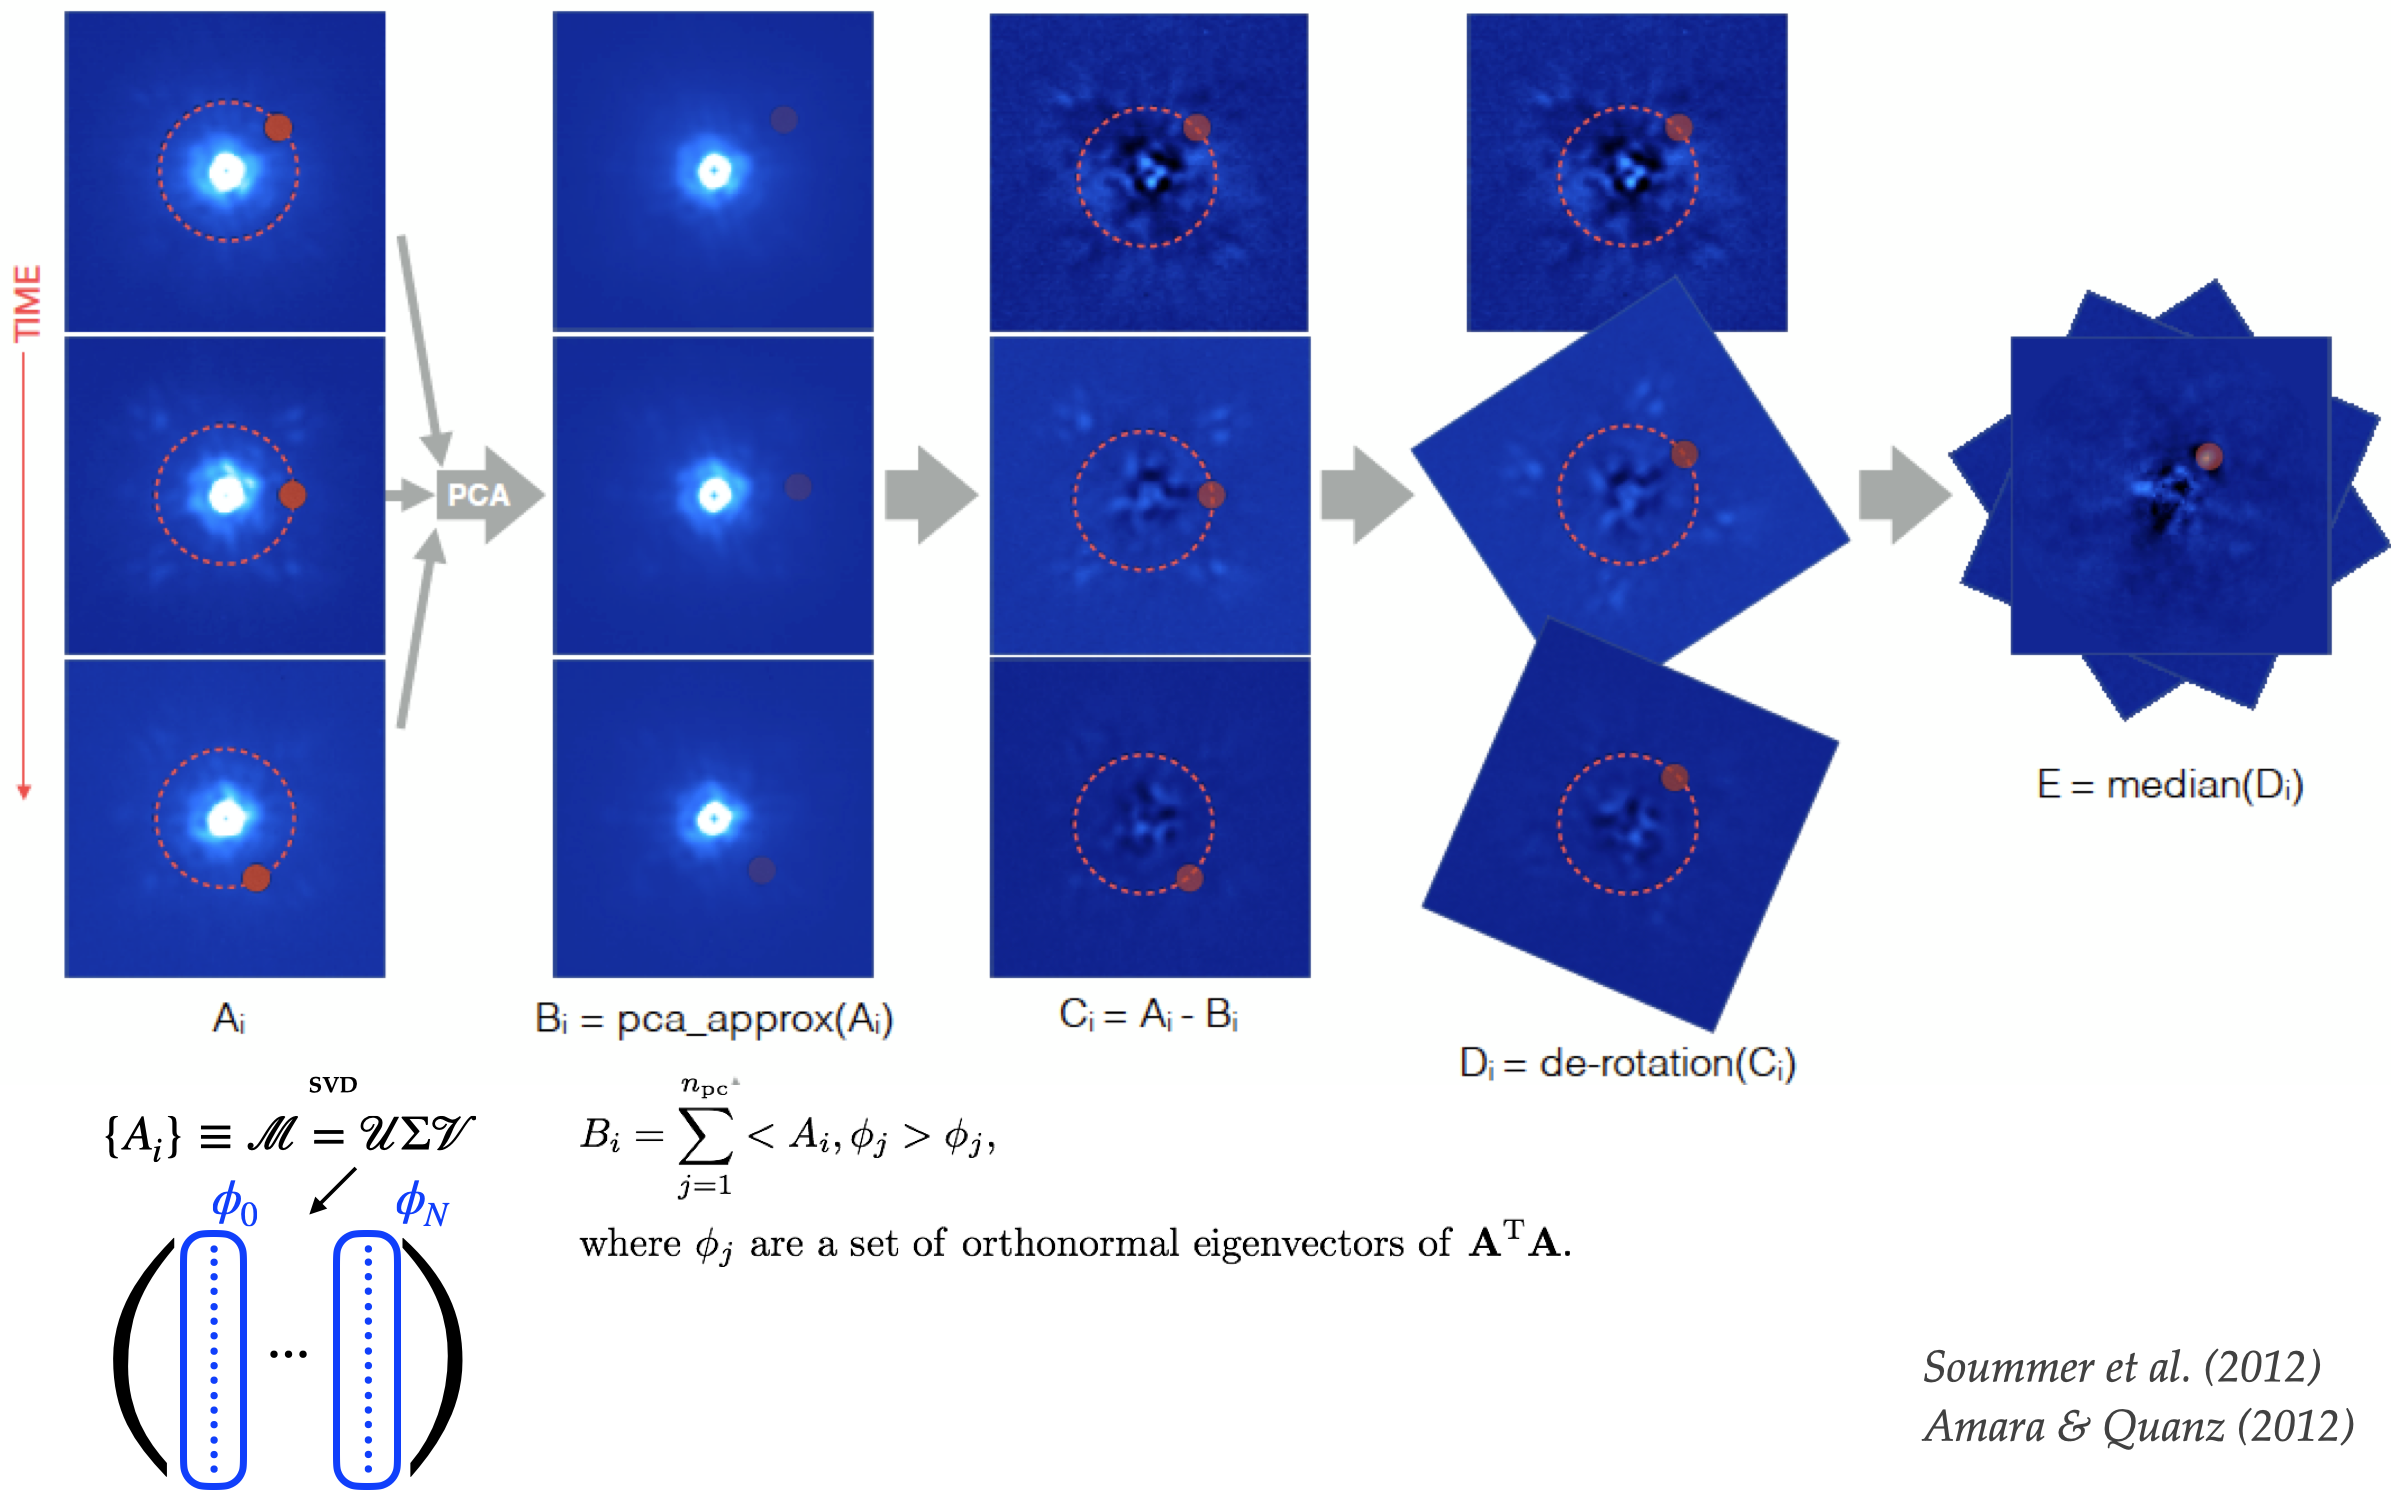

**Figure 3.2** - PCA-ADI concept. Compared to median-ADI (Fig. 3.1), only the model used for subtraction is refined. It is constructed from the projection of each image on the first $n_{\rm pc}$ principal components. The principal components are typically found by singular value decomposition, after converting the observed sequence of images $A_i$ into a 2D matrix (rows: time dimension, columns: linearized version of the images).

Let's set to 5 the number of principal components `ncomp` considered for model creation, and let's run the PCA algorithm (feel free to test other values):

In [18]:
ncomp = 5
fr_pca1 = pca(cube, angs, ncomp=ncomp, mask_center_px=None, imlib=imlib_rot, interpolation=interpolation,
              svd_mode='lapack')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:39:04
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 0.888 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.062402
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:01.188047
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The `svd_mode` argument sets how the Singular Value Decomposition should be calculated. 'lapack' is the default mode (exact SVD calculation by CPU through `numpy`), although other options may get faster results depending on input matrix and your machine (see description of `svd_mode` argument).

Let's visualize the final image. This time let's set the `grid` option on, to better read coordinates from the image:

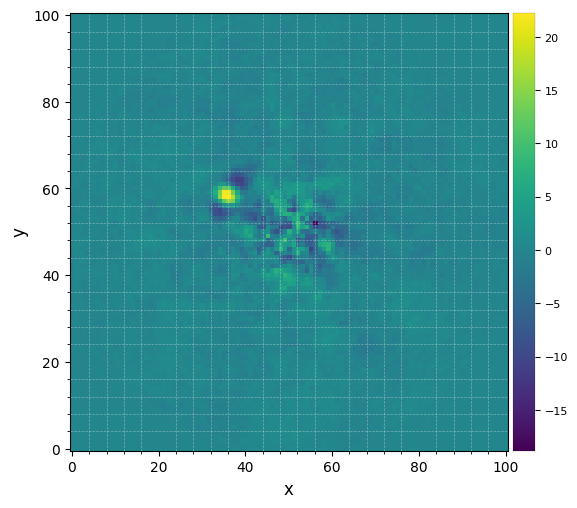

In [19]:
plot_frames(fr_pca1, grid=True)

The improvement is clear compared to previous reductions. Very low residuals are seen near the star, and the companion candidate appears as a bright point source surrounded by negative side-lobes. The procedure is also 15-20x faster than LOCI.

<font color=orange> **Question 3.6**: What is the origin of the negative side lobes? </font>
    
<font color=orange> **Question 3.7**: Are they always expected to be symmetric? </font>

Now let's see whether the candidate is significant. For that let's first set the x,y coordinates of the test point source based on the above image:

In [20]:
xy_b = (35.5,58.5)

Now let's compute the signal-to-noise ratio at that location, following the definition in [Mawet et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract).

In [21]:
snr1 = snr(fr_pca1, source_xy=xy_b, fwhm=fwhm_naco)
print(r"S/N = {:.1f}".format(snr1))

S/N = 8.3


One can also calculate a S/N ratio map over the whole image (this may take a couple of seconds depending on the size of your image):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:39:06
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


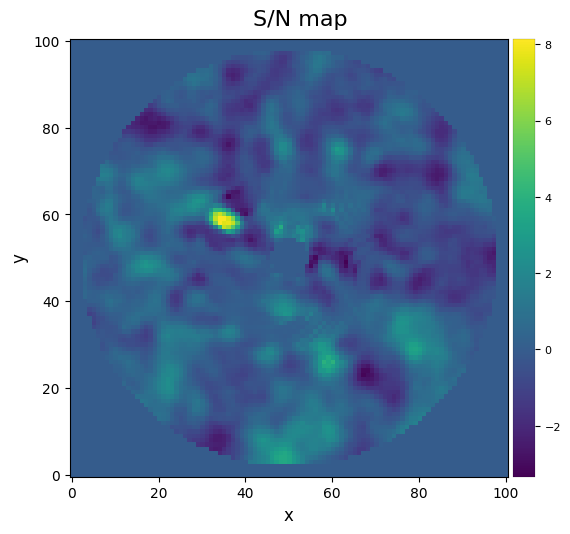

S/N map created using 5 processes
Running time:  0:00:02.790244
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [22]:
snrmap1 = snrmap(fr_pca1, fwhm_naco, plot=True)

Remember that S/N ratio is NOT the same as significance [Mawet et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract). Let's convert the measured S/N (Students statistics) into a Gaussian "sigma" with equivalent false alarm probability. This first involves calculating the radial separation of the candidate:

In [23]:
cy, cx = frame_center(snrmap1)
rad = np.sqrt((cy-xy_b[1])**2+(cx-xy_b[0])**2)

Now let's use the `significance` routine in VIP to operate the conversion:

In [24]:
sig1 = significance(snr1, rad, fwhm_naco, student_to_gauss=True)
print(r"{:.1f} sigma detection".format(sig1))

5.5 sigma detection


Congratulations! The detection is significant! You obtained a conspicuous direct image of an exoplanet! Although from this image (at a single wavelength) alone one cannot disentangle a true physically bound companion from a background star, this source has now been extensively studied: it corresponds to the giant planet Beta Pic b (e.g. [Lagrange et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...493L..21L/abstract), [Absil et al. 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract)).

[Go to the top](#Table-of-contents)

### 3.5.2. Optimizing the number of PCs for full-frame PCA-ADI

Clearly, modeling the background (leaked starlight + static and quasi-static speckles) with PCA leads to better images than subtracting a median frame. We chose 5 principal components (PCs), which greatly reduced the residual noise. A different number of PCs may lead to an even better detection.

For a given point source, the `pca` function can search for the optimal number of principal components which maximizes the S/N ratio of a given point source. When calling `pca`, this is done by setting `ncomp` to a tuple of 3 integers (initial value, last value, step) setting the range of explored npc values, and providing the `source_xy` coordinates of the point source of interest:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:39:08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 0.865 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.042829
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 31
Optimal number of PCs = 13, for S/N=9.277
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 35.5, 58.5
Flux in a centered 1xFWHM circular aperture = 114.815
Central pixel S/N = 11.529
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.277
Max S/N (shifting the aperture center) = 11.882
stddev S/N (shifting the aperture center) = 2.406



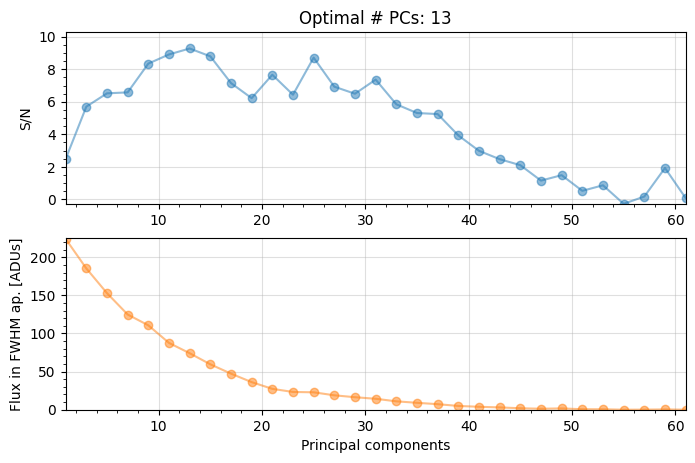

In [25]:
fr_pca2 = pca(cube, angs, fwhm=fwhm_naco, source_xy=xy_b, mask_center_px=None, 
              ncomp=(1, 61, 2), imlib=imlib_rot, interpolation=interpolation)

The optimal number of principal components is found to be 13 (note this value may change slightly if using a different imlib/interpolation, but should be in that ballpark).

In [26]:
ncomp_opt=13

<font color=orange> **Question 3.8**: Why is the shape of the S/N vs Principal components curve as seen above (i.e. increasing and then decreasing again)? </font>

Now let's look at the images computed using 5 PCs and 13 PCs (optimal npc found above), and compute the S/N maps:

In [27]:
snrmap1 = snrmap(fr_pca1, fwhm_naco, plot=False)
snrmap2 = snrmap(fr_pca2, fwhm_naco, plot=False)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:39:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 5 processes
Running time:  0:00:02.884443
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:39:47
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 5 processes
Running time:  0:00:02.700163
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


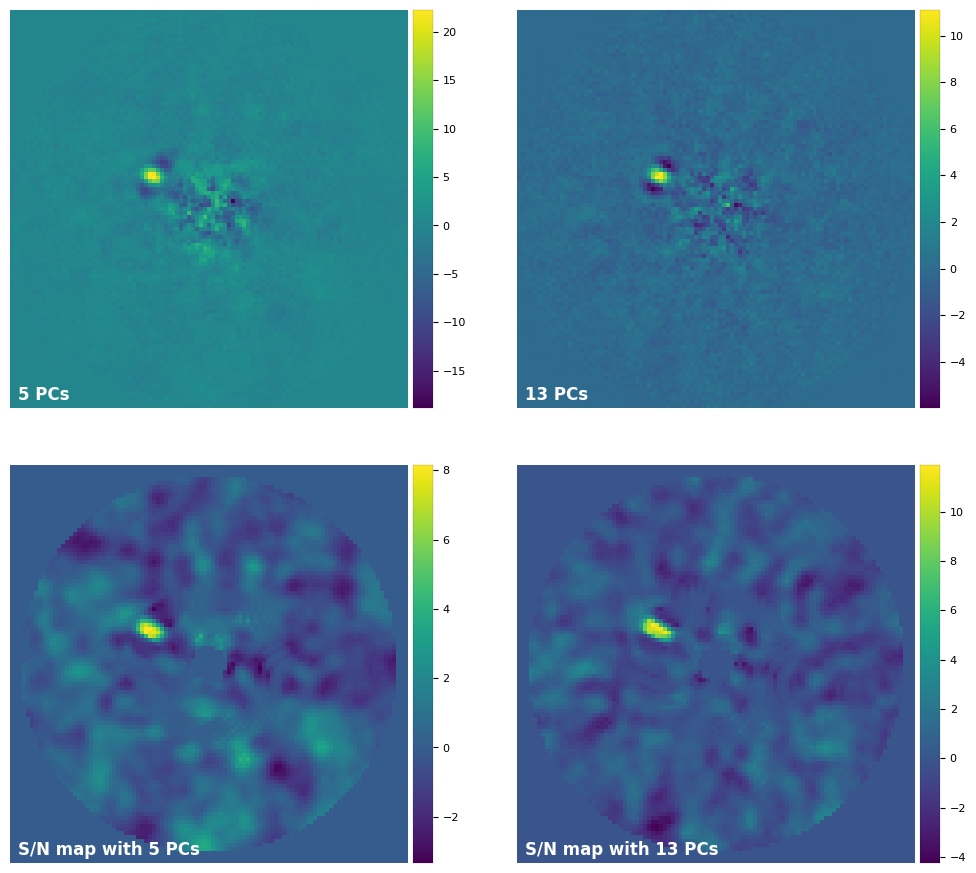

In [28]:
plot_frames((fr_pca1, fr_pca2, snrmap1, snrmap2), rows=2, dpi=100, colorbar=True, axis=False, 
            versp=0.01, horsp=0.2,
            label=('{} PCs'.format(ncomp), '{} PCs'.format(ncomp_opt), 
                   'S/N map with {} PCs'.format(ncomp), 'S/N map with {} PCs'.format(ncomp_opt)), 
            label_pad=8)

With 13 PCs we've increased the S/N of the point source (although the recovered flux is smaller). Let's compare the difference it makes on the significance:

In [29]:
snr2 = snr(fr_pca2, source_xy=xy_b, fwhm=fwhm_naco)
sig2 = significance(snr2, rad, fwhm_naco, student_to_gauss=True)

print(r"S/N = {:.1f} ({} PCs) VS. S/N = {:.1f} ({} PCs)".format(snr1, ncomp, snr2, ncomp_opt))
print(r"{:.1f} sigma detection ({} PCs) VS. {:.1f} sigma detection ({} PCs)".format(sig1, ncomp, sig2, ncomp_opt))

S/N = 8.3 (5 PCs) VS. S/N = 11.5 (13 PCs)
5.5 sigma detection (5 PCs) VS. 6.4 sigma detection (13 PCs)


<font color='orange'> **Question 3.9**: The result above was obtained for the full-frame PCA algorithm. For a given point source (i.e. at a given radius), is the optimal npc expected to be the same for PCA applied in a single annulus (encompassing the point source) and PCA on full frame? If not, would you intuitively expect it to be lower or higher for PCA on a single annulus? </font> 

The answer to Q5.6 will come in [Section 3.5.6](#3.5.6.-PCA-in-a-single-annulus). 

<font color=green> **Answer 3.6**: The negative side lobes stem from the presence of the point source in the constructed model used for subtraction. Since the field of view is rotating, the point source will span a range of position angles, and the stellar halo model built for subtraction for each frame of the cube (step B) will typically include some signal from the rotating point-source. </font>
    
<font color=green> **Answer 3.7**: The negative side lobes are not *necessarily* symmetric, as the field rotation rate (hence the rate at which the point source rotates) varies during the observation. The parallactic angle variation is the fastest when the target crosses the meridian. That being said, well-designed ADI observations typically aim for maximal field rotation, which is the case for an observation that is centered around meridian crossing, hence typically resulting in relatively symmetric negative signatures. </font>

<font color=green> **Answer 3.8**: The S/N first increases with $n_{\rm pc}$ due to a better modeling of the speckle pattern by including more PCs. After reaching the optimal $n_{\rm pc}$, the planet self-subtraction starts to dominate (i.e. a large $n_{\rm pc}$ will systematically lead to overfitting of the stellar PSF). </font>

[Go to the top](#Table-of-contents)

### 3.5.3. Full-frame PCA-ADI with a parallactic angle threshold

We can partially avoid the companion self-subtraction with full-frame PCA by applying a PA threshold for a given distance from the center. This is more efficient if a lot of rotation is present in the data.

This dataset happens to have a good range of rotation (about ~80 deg), and is therefore suitable for that:

Text(0, 0.5, 'Derotation angles')

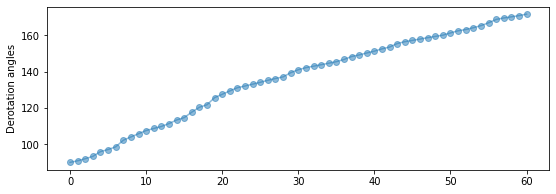

In [30]:
figure(figsize=(9,3))
plot(angs, 'o-', alpha=0.5)
ylabel('Derotation angles')

<font color=orange> **Question 3.10** For a given observatory, where are the most ideal targets (in terms of celestial coordinates) to apply the ADI strategy (i.e. the ones leading to an optimal parallactic angle variation)? </font>

The `pca` function in ``VIP`` accepts a parameter `source_xy` for defining a location of interest for which the rotation threshold will be applied. The parameter `delta_rot` sets the minimum amount of linear motion in terms of the FWHM to include other frames when building the PCA library for each image of the sequence. In the following example we set the threshold to 1 FWHM, which will significantly reduce companion self-subtraction. We also increase the npc to 30.

In [31]:
fr_pca_optlib = pca(cube, angs, ncomp=30, source_xy=xy_b, delta_rot=1, fwhm=fwhm_naco,
                    imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:39:50
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 0.868 GB
Size LIB: min=30.0 / 1st QU=33.0 / med=39.0 / 3rd QU=44.0 / max=52.0
Done de-rotating and combining
Running time:  0:00:02.657883
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


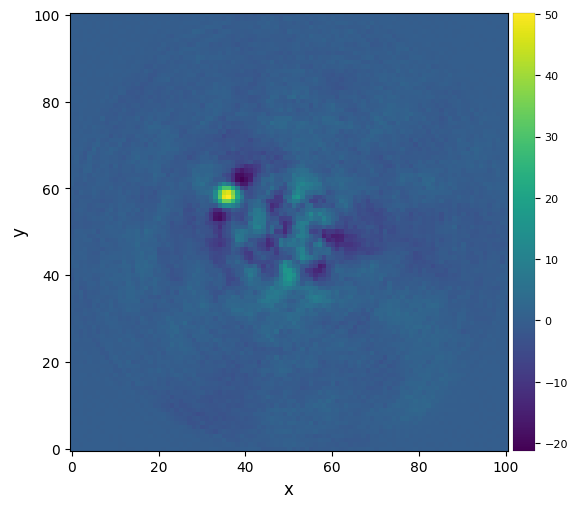

In [32]:
plot_frames(fr_pca_optlib)#, backend='bokeh')

<font color=orange> **Question 3.11**: As can be seen above, a PA threshold reduces the self-subtraction (notice the maximum in the scale), but also leads to a less efficient modeling and subtraction of speckle in the innermost part of the image. 
Why is that so?</font>

We can have a quick report on the last two frames, obtained without and with parallactic angle threshold, and in particular inspect the effect on the flux and S/N ratio of the companion:

In [33]:
snr(fr_pca2, xy_b, fwhm_naco, verbose=True)

S/N for the given pixel = 11.529
Integrated flux in FWHM test aperture = 114.815
Mean of background apertures integrated fluxes = -4.424
Std-dev of background apertures integrated fluxes = 10.105


11.529242341583403

In [34]:
snr(fr_pca_optlib, xy_b, fwhm_naco, verbose=True)

S/N for the given pixel = 7.632
Integrated flux in FWHM test aperture = 543.275
Mean of background apertures integrated fluxes = -26.145
Std-dev of background apertures integrated fluxes = 72.897


7.631736467542127

The companion flux on ``fr_pca_optlib`` is much larger than on ``fr_pca2`` (best full-frame PCA frame without the application of a rotation threshold) because we've reduced self-subtraction (companion over subtraction). On the other hand, the S/N has decreased due to the larger residual speckle noise.

<font color=green> **Answer 3.10** Targets with a declination $\delta$ very different to the latitude $L$ of the observatory will have a very slow parallactic angle variation rate, and are hence not ideal for ADI. On the other extreme, an object whose $\delta$ matches almost exactly $L$ (within a few degrees) will have all the field rotation happening in a matter of minutes, around the time when the object crosses the local meridian (north-south imaginary line) - called transit. This is not ideal either. The best targets for ADI are thus the ones where $|\delta-L|$ is neither too small ($>5$deg) nor too large ($\lesssim 35$deg), as is the case for beta Pic as observed from the Very Large Telescope ($|\delta-L| \approx 27$deg) </font>

<font color=green> **Answer 3.11** Using a PA threshold implies that for a given image to be modeled, the PCA library will be built using exclusively images taken sufficiently far away in time (hence with less correlated speckle). This in turn can lead to a less efficient speckle subtraction. This effect can be particularly stronger in the innermost parts of the image, where a given threshold in terms of linear motion implies a larger delay than for the outer parts of the image. </font>

[Go to the top](#Table-of-contents)

### 3.5.4. PCA for big datacubes

Computing the PCA model can be a CPU and memory intensive procedure, when working with thousands of large frames, let's say cubes with shapes [10000, 600, 600]. Such cube won't fit on the memory of a normal laptop or desktop computer. With ``VIP`` we just need to provide a positive integer value to the ``batch`` parameter of the ``pca`` function to alleviate this issue. Let's compute the incremental PCA on our toy cube (even if its size does not require it):

In [35]:
fr_increm = pca(cube, angs, ncomp=19, fwhm=fwhm_naco, batch=31, imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:39:53
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 0.858 GB
Cube size = 0.002 GB (61 frames)
Batch size = 31 frames (0.001 GB)

Batch 1/2	shape: (31, 101, 101)	size: 1.3 MB
Batch 2/2	shape: (30, 101, 101)	size: 1.2 MB
Running time:  0:00:00.177417
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Reconstructing and obtaining residuals
Running time:  0:00:01.285216
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


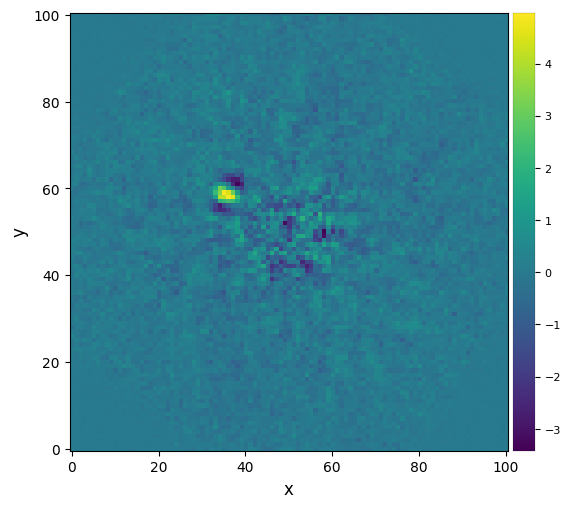

In [36]:
plot_frames(fr_increm)#, backend='bokeh')

[Go to the top](#Table-of-contents)

### 3.5.5. Annular PCA

PCA can also be performed on concentric annuli, and including a parallactic angle threshold when building the PCA library associated to each image. This is the same idea used before in full-frame when the position of a source of interest was defined except that the PA threshold here will be adjusted depending on the radial distance of each annulus from the star. PCA can be computed in full annuli or in separate annular segments (``n_segments``). The computational cost increases accordingly.

The function `pca_annular` processes the cube in annular fashion in a serial or parallel way. Setting `nproc` to an integer will use that number of CPUs in multiprocessing, while setting it to `None` will automatically set it to half the number of CPUs available on the machine. The improvement in speed is noticeable in multi-core machines. 

Let's try `pca_annular` with 3 segments per annulus, 6 principal components, a 0.2 FWHM rotation threshold, and in multi-processing mode:

In [37]:
fr_pca_an6 = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp=6, asize=fwhm_naco, delta_rot=0.2, nproc=None, 
                          n_segments=3, svd_mode='lapack', imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:39:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:00:00.156378
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:00:00.547436
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.58    Ann center:  12    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:00:01.311463
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  3.27    Ann center:  16    N segments: 3 
Done PCA with lapack for curr

The parameter `ncomp` can be set to *auto* for letting the algorithm define automatically the number of PCs for each annular patch (instead of fixing it for all of them). The optimal value is found when the standard deviation of the residuals after the subtraction of the PCA approximation drops below a given (absolute) tolerance `tol` while progressively increasing the number of principal components. Note that this is different to finding the optimal $n_{\rm pc}$ that maximizes the S/N ratio of a given companion companion (as the former does not require any companion).

In [38]:
fr_pca_auto = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', svd_mode='lapack', asize=fwhm_naco, 
                          delta_rot=0.2, tol=0.1, nproc=None, imlib=imlib_rot, interpolation=interpolation, 
                          verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:40:04
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.156742
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:02.242600
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.58    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:04.607690
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  3.27    Ann center:  16    N segments: 1 
Done PCA with lapack for curr

Now let's compare both images:

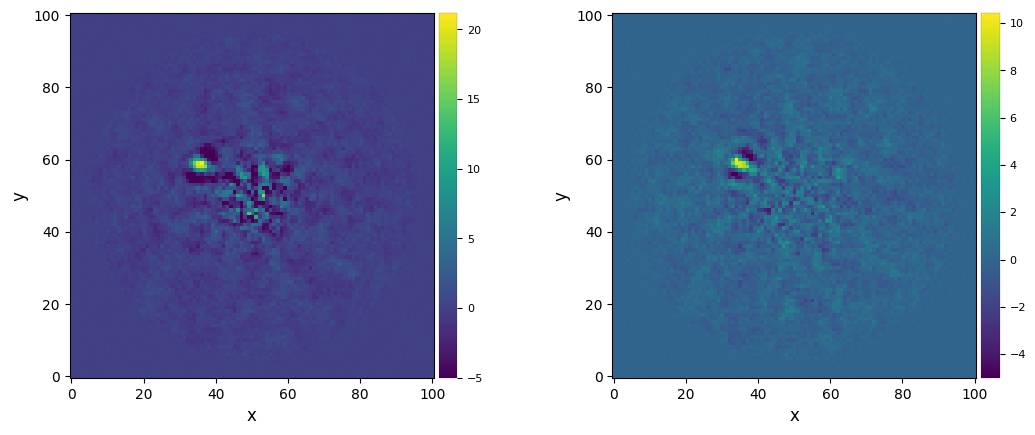

In [39]:
plot_frames((fr_pca_an6, fr_pca_auto), dpi=100, vmin=-5, colorbar=True)

And let's compare the S/N ratio measured in each case: 

In [40]:
snr1 = snr(fr_pca_an6, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 9.333
Integrated flux in FWHM test aperture = 197.882
Mean of background apertures integrated fluxes = -6.165
Std-dev of background apertures integrated fluxes = 21.359


In [41]:
snr2 = snr(fr_pca_auto, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 9.748
Integrated flux in FWHM test aperture = 85.703
Mean of background apertures integrated fluxes = -3.377
Std-dev of background apertures integrated fluxes = 8.928


Despite the relatively high S/N ratio, the planet appears significantly self-subtracted. This is because `delta_rot` was set to a low value. Setting it to a value larger than 0.3 leads to a bug (feel free to test it). This is because for a given image to be modelled, not enough images are found in the rest of the datacube complying with the PA threshold condition for the innermost annuli. To solve this issue, one can increase the radius `radius_int` of the innermost annulus where annular PCA starts.

In [42]:
fr_pca_ann_mask = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', asize=fwhm_naco, radius_int=5,
                              delta_rot=1, nproc=None, svd_mode='lapack', imlib=imlib_rot, 
                              interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:40:19
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 9, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 34.99    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.611394
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 21.88    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:02.254381
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh: 15.87    Ann center:  17    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:03.674298
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh: 12.44    Ann center:  21    N segments: 1 
Done PCA with lapack for curre

When using PCA with a numerical mask covering the inner part of the image, it is recommended to explicitly set the optional argument `mask_val=0` (the value used for missing values not calculated by PCA). This will tell the image (de)rotation algorithm which pixels are part of a mask. These values will then be interpolated before rotation (using a Gaussian kernel size set by `ker`), and masked again after rotation. This will prevent a sharp transition between the mask and the signals near the mask. This sharp transition in the inner part of the image would otherwise lead to either Gibbs-related artefacts (when using the FFT-based rotation method), or ringing artefacts (when using an interpolation-based method). See the difference below. Similar tests are also shown in Tutorial `7. FFT- vs interpolation-based image operations`.

In [43]:
fr_pca_ann_mask0 = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', asize=fwhm_naco, radius_int=5,
                              delta_rot=1, nproc=None, svd_mode='lapack', imlib=imlib_rot, 
                              interpolation=interpolation, mask_val=0, ker=1)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:40:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 9, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 34.99    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.824963
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 21.88    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:02.353793
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh: 15.87    Ann center:  17    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:03.627343
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh: 12.44    Ann center:  21    N segments: 1 
Done PCA with lapack for curre

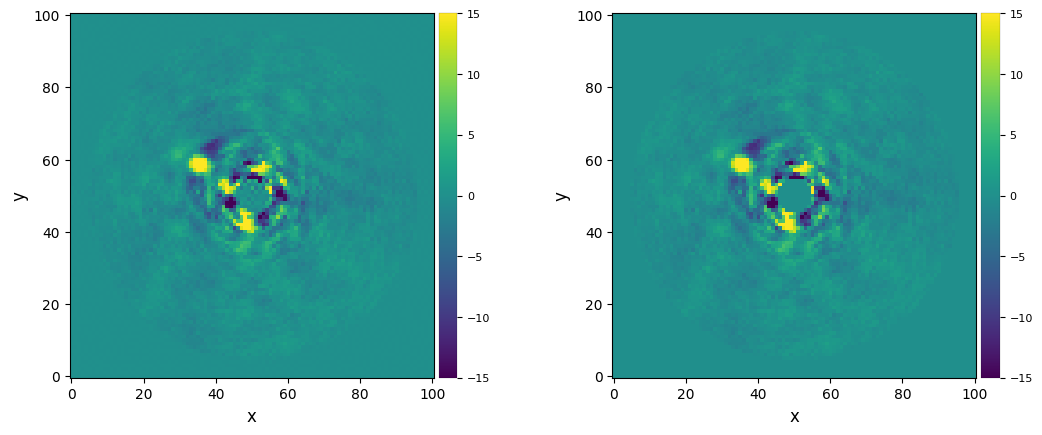

In [44]:
plot_frames((fr_pca_ann_mask, fr_pca_ann_mask0), vmin=-15, vmax=15)

For more flexibility, `delta_rot` can also be set to a tuple of 2 values instead of a scalar. If a tuple, it corresponds to the PA thresholds for the innermost and outermost annuli in the image (linearly interpolated in between).

In [45]:
fr_pca_ddrot = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', asize=fwhm_naco, delta_rot=(0.2,1), nproc=None, 
                          svd_mode='lapack', imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:40:39
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.156243
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 11.00    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:02.332116
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  8.64    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:04.068793
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  7.63    Ann center:  16    N segments: 1 
Done PCA with lapack for curr

Let's compare with the image obtained with a single PA threshold at all radii.

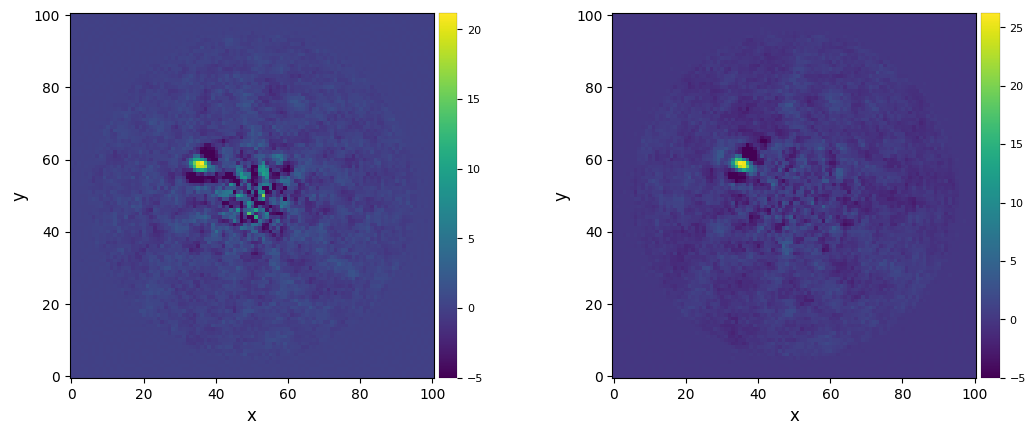

In [46]:
plot_frames((fr_pca_an6, fr_pca_ddrot), dpi=100, vmin=-5, colorbar=True)

The residual speckle noise is now lower in the innermost part of the image.

[Go to the top](#Table-of-contents)

### 3.5.6. PCA in a single annulus

Once a companion candidate has been identified, the fastest way to recover (and hence characterize) it is to apply PCA on a single annulus encompassing the companion candidate. This is used in particular for the characterization of companion candidates with the negative fake companion technique (see `Tutorial 5. Planet forward modeling`). The relevant function is called `pca_annulus`, which requires the radius `r_guess` of the annulus to be provided, and its `annulus_width`.

In [47]:
ncomp_test = 5
pca_ann_test = pca_annulus(cube, angs, ncomp=ncomp_test, annulus_width=3*fwhm_naco, r_guess=rad,
                           imlib=imlib_rot, interpolation=interpolation)

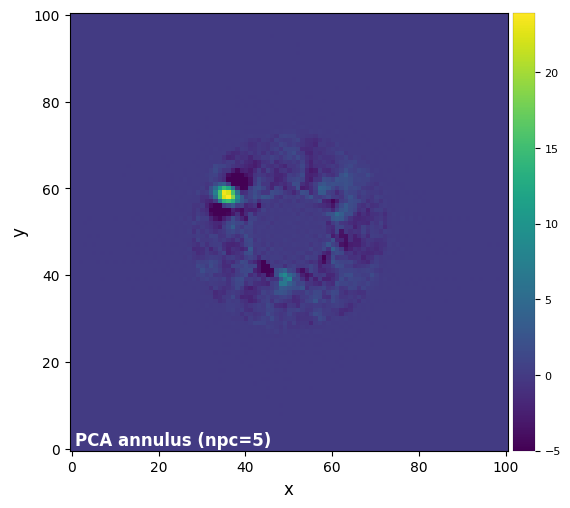

In [48]:
plot_frames(pca_ann_test, label='PCA annulus (npc={:.0f})'.format(ncomp_test),
            dpi=100, vmin=-5, colorbar=True)

Let's now use `pca_grid` to search for the optimal $n_{\rm pc}$ that maximizes the S/N ratio of a given point source. `pca_grid` encompasses both the `pca` and `pca_annulus` function, depending on whether `mode='fullfr'` or `mode='annular'`, respectively. This will allow us to answer Q3.9 we posed earlier: <font color=orange> Is the optimal number of PCs the same for full-frame PCA and PCA in an annulus? </font>

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:40:52
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.026891
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 31
Optimal number of PCs = 13, for S/N=9.277
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 35.5, 58.5
Flux in a centered 1xFWHM circular aperture = 114.815
Central pixel S/N = 11.529
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.277
Max S/N (shifting the aperture center) = 11.882
stddev S/N (shifting the aperture center) = 2.406

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:41:28
―――――

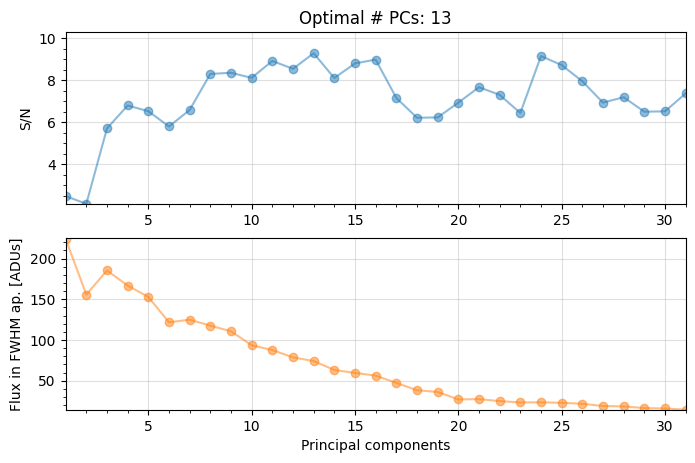

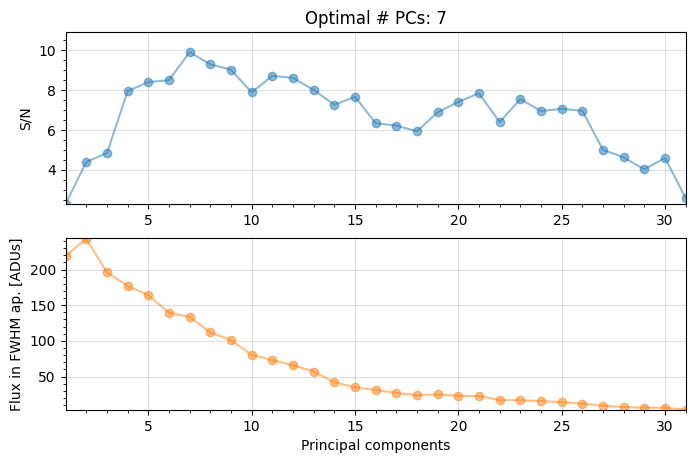

In [49]:
# full frame
res_ff_opt = pca_grid(cube, angs, fwhm=fwhm_naco, range_pcs=(1,31,1), source_xy=xy_b, mode='fullfr', 
                      imlib=imlib_rot, interpolation=interpolation, full_output=True, plot=True)

# single annulus with no PA threshold
res_ann_opt = pca_grid(cube, angs, fwhm=fwhm_naco, range_pcs=(1,31,1), source_xy=xy_b, mode='annular',
                       annulus_width=3*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

For full-frame PCA the optimal npc is found to be 13 (as already seen in [Sec. 3.5.2](###3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI)).

For PCA on a single annulus, the optimal npc is found to be 7, hence lower.

Let's plot the final images below. Note that since we ran `pca_grid` with the `full_output=True` option, both final images and optimal number of pcs are returned (among other outputs).

In [50]:
_, final_ff_opt, _, opt_npc_ff = res_ff_opt
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

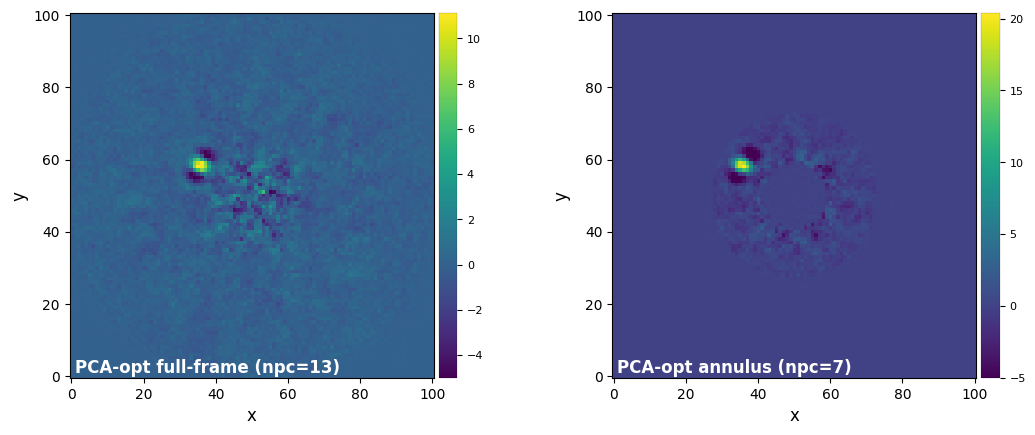

In [51]:
plot_frames((final_ff_opt, final_ann_opt), label=('PCA-opt full-frame (npc={:.0f})'.format(opt_npc_ff), 
                                                  'PCA-opt annulus (npc={:.0f})'.format(opt_npc_ann)),
            dpi=100, vmin=-5, colorbar=True)

<font color='green'> **Answer 5.6**: The optimal $n_{\rm pc}$ is in general lower for PCA on a single annulus than on full frame. Intuitively, one could expect this result due to the smaller number of pixels in the annular case compared to the full frame case. With less pixels (i.e. a smaller matrix for singular value decomposition), a lower $n_{\rm pc}$ is sufficient to achieve similar (or better) modeling of speckle. Conversely a lower $n_{\rm pc}$ would be enough to cause overfitting. </font> 

[Go to the top](#Table-of-contents)

## 3.6. NMF

A PSF reference can be modelled using a low-rank approximation different than PCA (which relies on singular value decomposition). Non-negative matrix factorization can be used instead ([Gomez Gonzalez et al. 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154....7G/abstract); [Ren et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...852..104R/abstract)). Instead of $M = U\Sigma V$ (SVD), non-negative matrix factorization can be written as $M = \mathcal{W} \mathcal{H}$, where both matrices are non-negative, and the columns of $\mathcal{H}$ are the non-zero components onto which the images are projected (note that the residuals after model subtraction can be negative though).

The two matrices are typically found iteratively. Currently, the default method in VIP is based on the `scikit-learn` implementation of NMF, which uses the principal components obtained by SVD as first guess of the iterative process. Therefore, the results can look fairly similar to PCA, in particular if the PCs are mostly non-negative.

### 3.6.1. Full-frame NMF

Full-frame NMF is simply done by calling the `nmf` function. Input arguments are mostly similar to `pca`, apart from `init_svd` which sets the method used to estimate the initial SVD from which the solution is iteratively found.

In [52]:
fr_nmf = nmf(cube, angs, ncomp=14, max_iter=10000, init_svd='nndsvdar', mask_center_px=None, imlib=imlib_rot, 
             interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:42:03
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:05.284530
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done NMF with sklearn.NMF.
Running time:  0:00:05.287277
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:00:06.399365
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


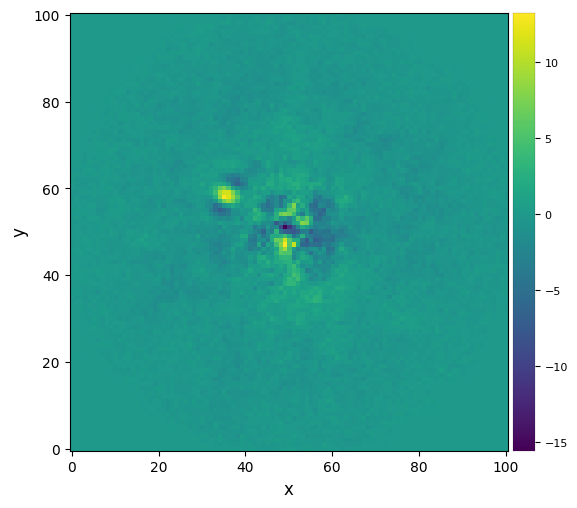

In [53]:
plot_frames(fr_nmf, dpi=100, colorbar=True)#, backend='bokeh')

In [54]:
snr_nmf = snr(fr_nmf, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 7.377
Integrated flux in FWHM test aperture = 126.136
Mean of background apertures integrated fluxes = -2.317
Std-dev of background apertures integrated fluxes = 17.013


[Go to the top](#Table-of-contents)

### 3.6.2. Annular NMF

The same as above can be performed in concentric annuli (new since v1.0.0):

In [55]:
fr_nmf_ann = nmf_annular(cube, angs, ncomp=9, max_iter=10000, init_svd='nndsvdar', radius_int=0, 
                         fwhm=fwhm_naco, asize=fwhm_naco, imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:42:09
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Ann 4    PA thresh:  6.54    Ann center:  16    N segments: 1 
Ann 5    PA thresh:  6.36    Ann center:  21    N segments: 1 
Ann 6    PA thresh:  6.24    Ann center:  25    N segments: 1 
Ann 7    PA thresh:  6.16    Ann center:  30    N segments: 1 
Ann 8    PA thresh:  6.11    Ann center:  35    N segments: 1 
Ann 9    PA thresh:  6.06    Ann center:  39    N segments: 1 
Ann 10    PA thresh:  6.17    Ann center:  43    N segments: 1 
Done derotating and combining.
Running time:  0:02:57.056161
―――――――――――――――――――――――――――――――――――――――――――――

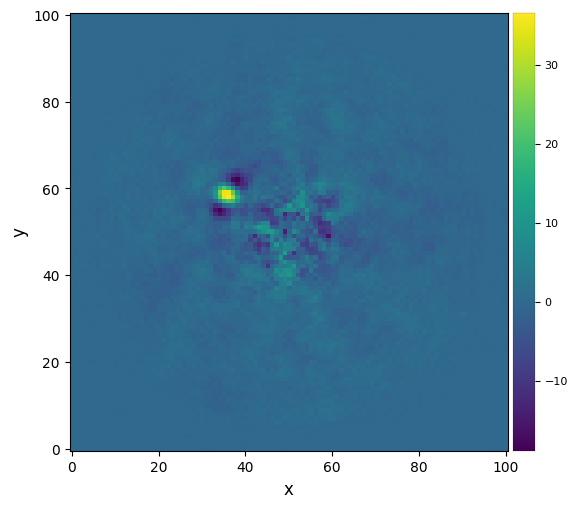

In [56]:
plot_frames(fr_nmf_ann, dpi=100, colorbar=True)

In [57]:
snr_nmf_ann = snr(fr_nmf_ann, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 8.435
Integrated flux in FWHM test aperture = 368.851
Mean of background apertures integrated fluxes = -13.030
Std-dev of background apertures integrated fluxes = 44.234


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:45:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


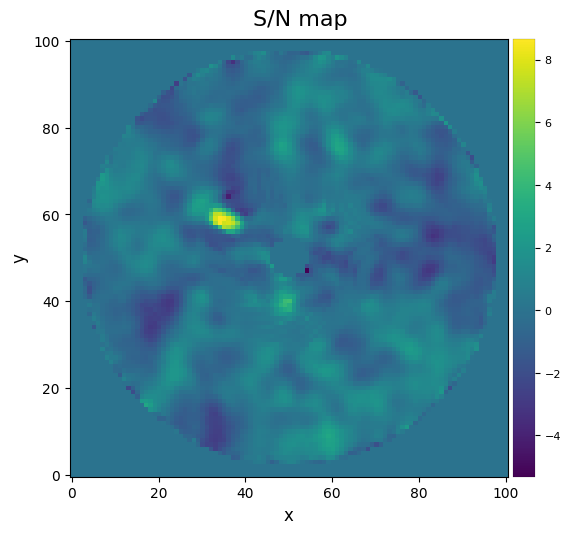

S/N map created using 5 processes
Running time:  0:00:02.824514
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [58]:
snrmap_nmf_ann = snrmap(fr_nmf_ann, fwhm_naco, plot=True)

[Go to the top](#Table-of-contents)

## 3.7. LLSG

Local Low-rank plus Sparse plus Gaussian-noise decomposition ([Gomez Gonzalez et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...589A..54G/abstract)) proposes a three terms decomposition to improve the detectability of point-like sources in ADI data. It aims at decomposing ADI cubes into L+S+G (low-rank, sparse and Gaussian noise) terms. Separating the noise from the S component (where the moving planet should stay) allows us to increase the S/N of potential planets.

Let's try it out:

In [59]:
fr_llsg = llsg(cube, angs, fwhm_naco, rank=5, thresh=1, max_iter=20, random_seed=10, 
               imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:45:09
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Annuli = 5
Processing annulus: 
1 : in_rad=0, n_segm=4
2 : in_rad=10, n_segm=4
3 : in_rad=20, n_segm=4
4 : in_rad=30, n_segm=4
5 : in_rad=40, n_segm=4

Running time:  0:00:03.037431
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's plot it along the full-frame PCA-ADI result, after the optimization of the number of PCs:

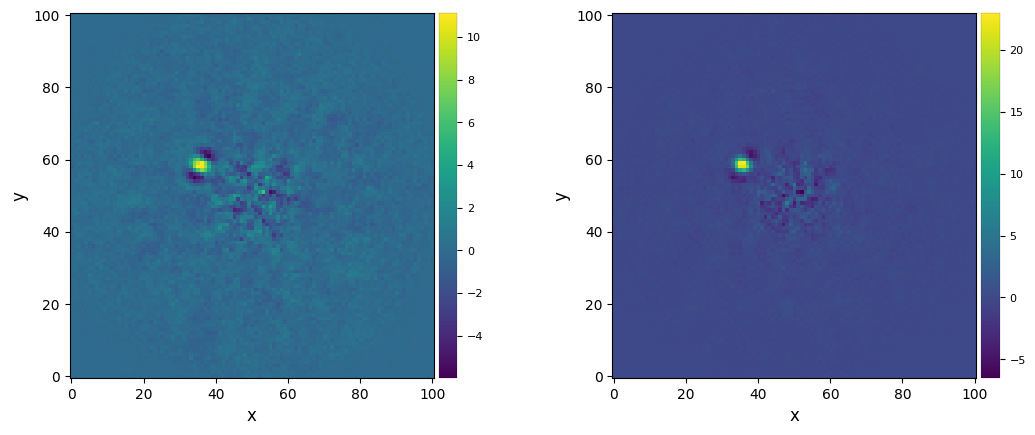

In [60]:
plot_frames((final_ff_opt, fr_llsg))#, backend='bokeh')

The computation of S/N ratio and S/N maps when the noise has been almost totally supressed becomes problematic (both from a theoretical and computational points of view). Let's nevertheless compute them for reference:

In [61]:
snr_llsg = snr(fr_llsg, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 29.064
Integrated flux in FWHM test aperture = 224.276
Mean of background apertures integrated fluxes = -1.713
Std-dev of background apertures integrated fluxes = 7.597


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-24 19:45:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


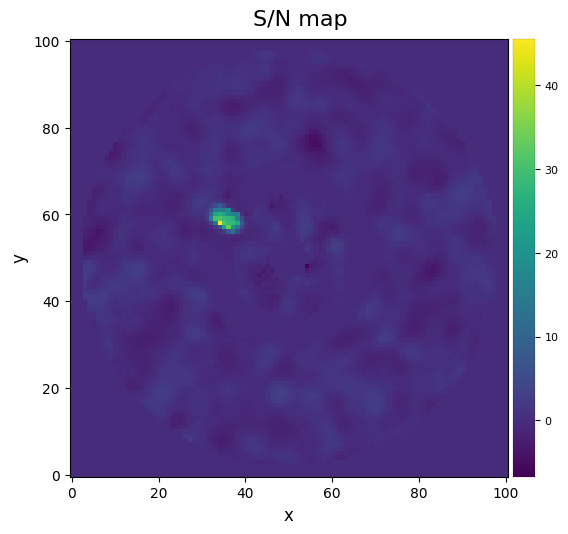

S/N map created using 5 processes
Running time:  0:00:02.831033
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [62]:
snrmap_llsg = snrmap(fr_llsg, fwhm_naco, plot=True)

[Go to the top](#Table-of-contents)

## 3.8. ANDROMEDA

Another approach to find point sources in ADI sequences consists in i) subtracting pairs of images separated by a known amount of rotation (typically 0.5 FWHM to produce a specific positive-negative signature); ii) find this residual signature using a maximum match-filter; iii) evaluate the likelihood that a point source is present at each pixel and the corresponding photometry. 
This is what ANDROMEDA does ([Mugnier et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009JOSAA..26.1326M/abstract), [Cantalloube et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26A...582A..89C/abstract)). The principle is summarized in this figure:

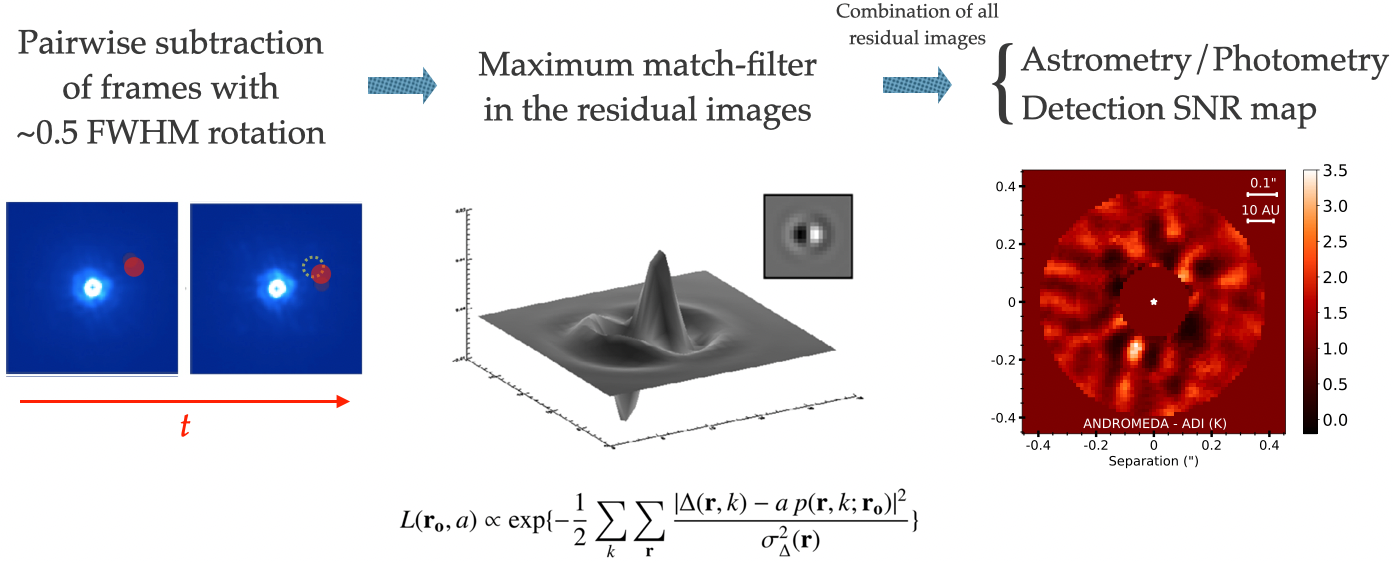

ANDROMEDA follows an inverse-problem approach since it involves a model for the expected positive-negative signature of a point source, and finding the optimal coefficients which minimize residuals between model and observed residual images.

The `andromeda` function in VIP requires the calculation of the oversampling factor (i.e. ratio between Nyquist sampling and actual pixel sampling):

In [63]:
lbda = VLT_NACO['lambdal']
diam = VLT_NACO['diam']
resel = (lbda/diam)*206265 # lambda/D in arcsec
nyquist_samp = resel/2.
oversamp_fac = nyquist_samp/pxscale_naco
oversamp_fac

1.7577458534791308

Let's now try it:

In [64]:
res = andromeda(cube, oversamp_fac, angs, psf, filtering_fraction=.25,
              min_sep=.5, annuli_width=1., roa=2, opt_method='lsq',
              nsmooth_snr=18, iwa=2, owa=None, precision=50, fast=False, 
              homogeneous_variance=True, ditimg=1.0, ditpsf=None, tnd=1.0,
              total=False, multiply_gamma=True, nproc=1, verbose=False)

In [65]:
flux, snr, snr_norm, stdcontrast, stdcontrast_norm, likelihood, ext_radius = res

One can then plot the SNR and flux of a putative companion at each pixel:

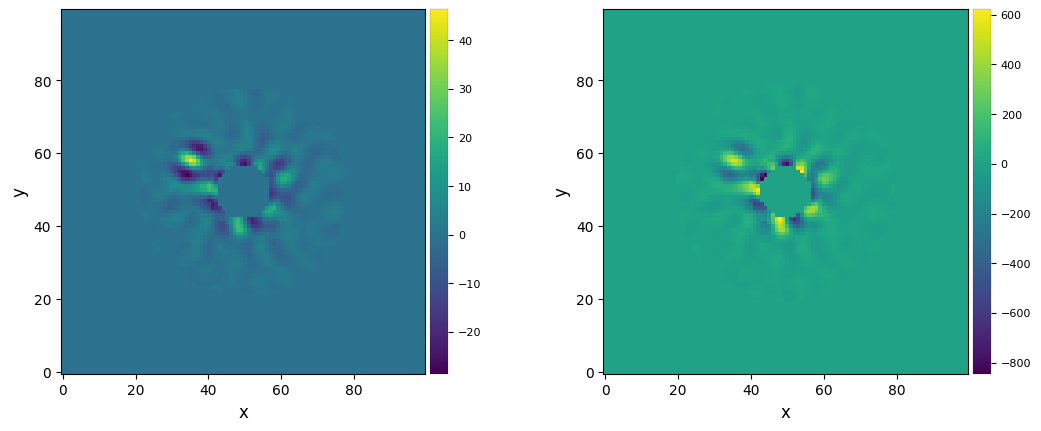

In [66]:
plot_frames((snr_norm, flux))#, backend='bokeh')

[Go to the top](#Table-of-contents)

## 3.9. Summary mosaic

Let's take a look at the final residual frames produced by the different algorithms:

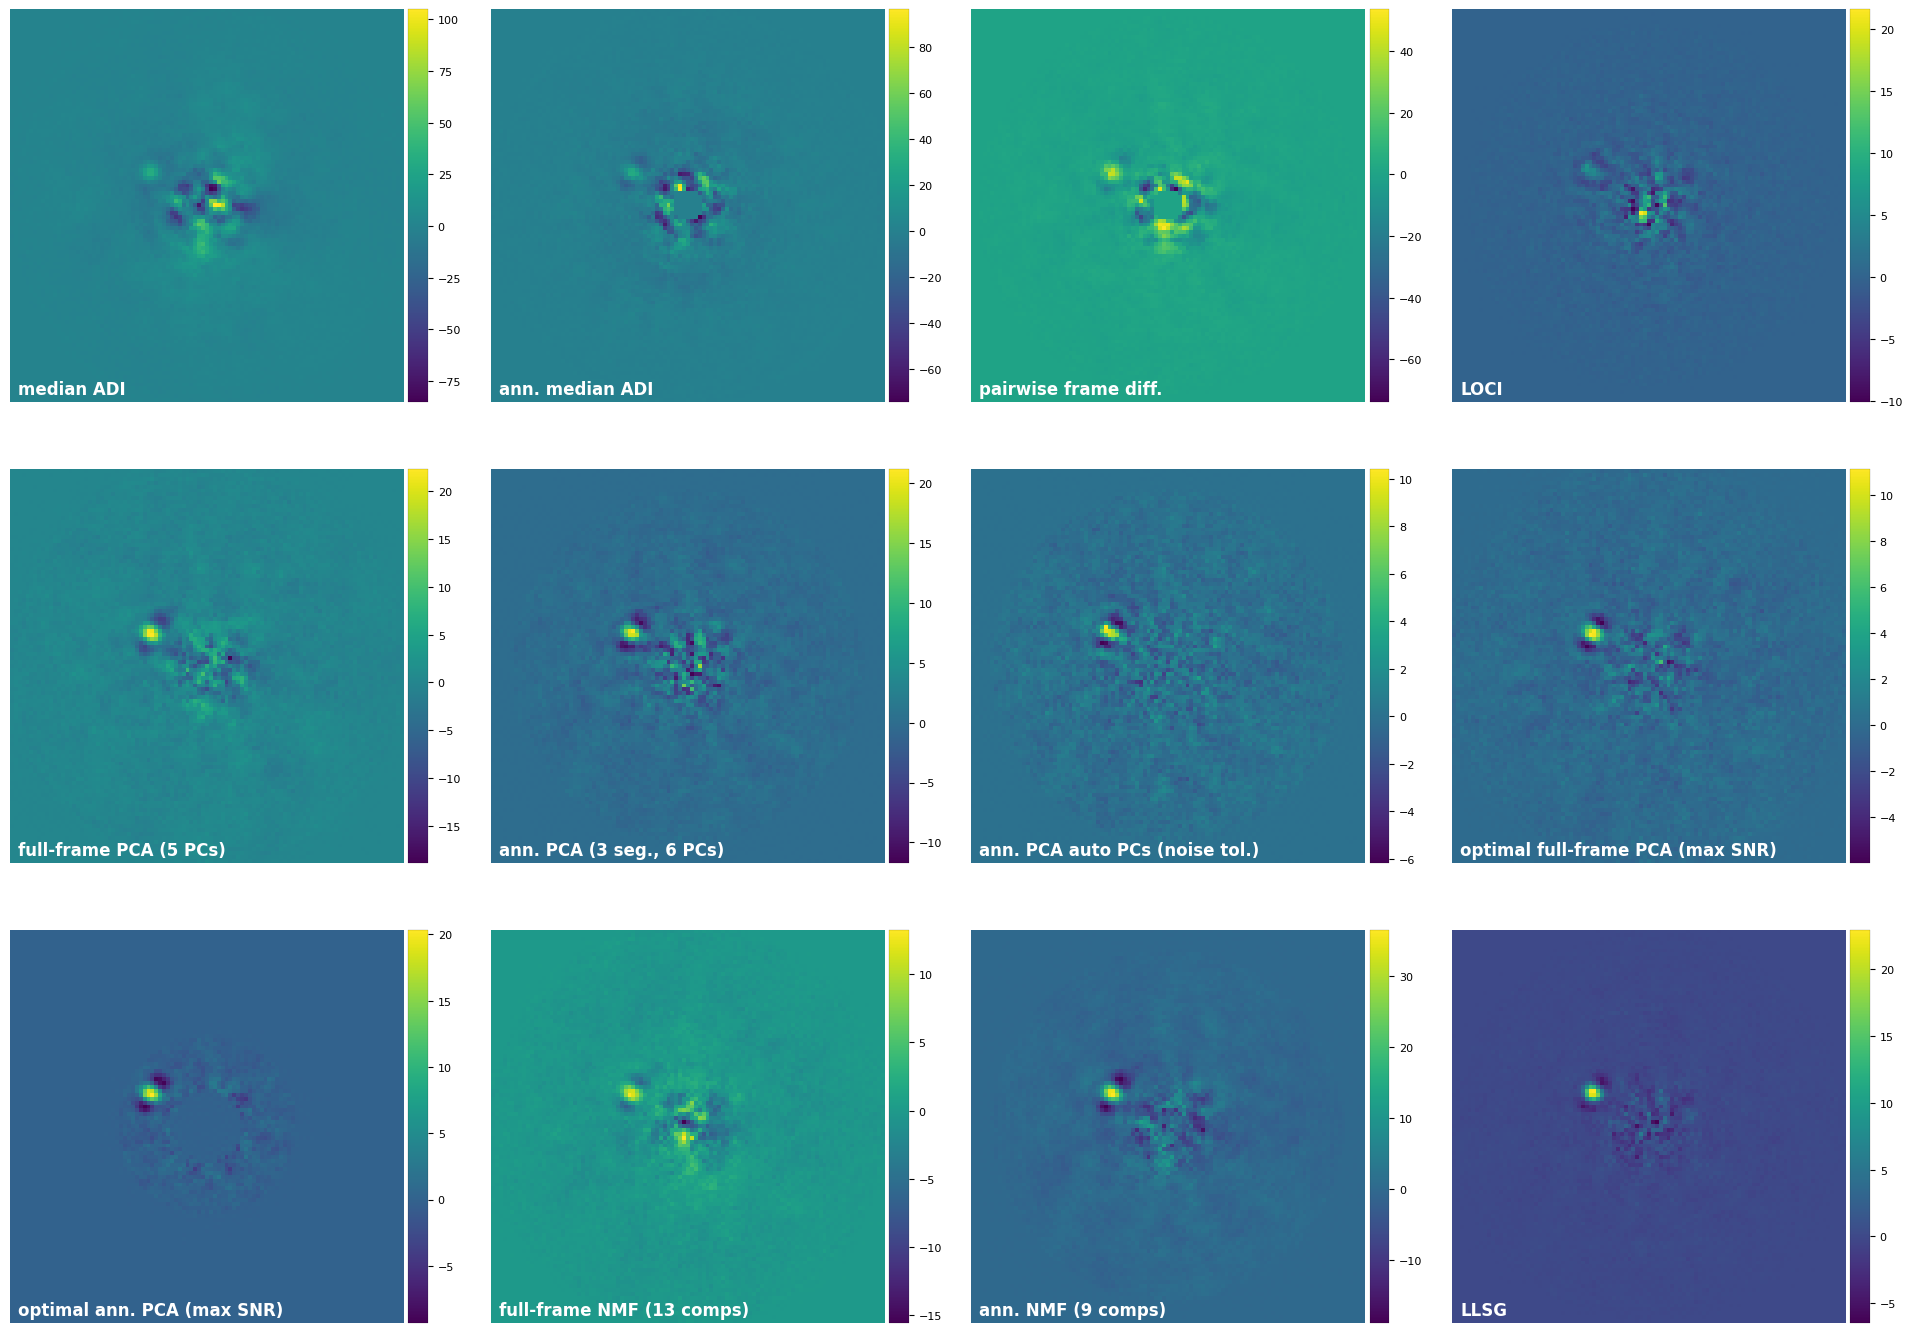

In [67]:
plot_frames((fr_adi, fr_adi_an, fr_fdiff, fr_lstsq, fr_pca1, fr_pca_an6, 
             fr_pca_auto, final_ff_opt, final_ann_opt, fr_nmf, fr_nmf_ann, fr_llsg), 
            rows=3, colorbar=True, label_size=12, label_pad=8, axis=False, versp=0.05, horsp=0.15, 
            label=('median ADI', 'ann. median ADI', 'pairwise frame diff.', 'LOCI', 
                   'full-frame PCA (5 PCs)', 'ann. PCA (3 seg., 6 PCs)', 
                   'ann. PCA auto PCs (noise tol.)', 'optimal full-frame PCA (max SNR)', 
                   'optimal ann. PCA (max SNR)', 'full-frame NMF (13 comps)', 'ann. NMF (9 comps)','LLSG'))

Check out tutorial `4. Metrics` for more details on evaluating i) the significance of a potential point source, ii) the achieved contrast in your image, in the form of contrast curves.

[Go to the top](#Table-of-contents)